# IBM Applied Data Science Capstone Course by Coursera
Opening a BBQ resuaurant


## Part 1 Introduction 
> where you discuss the business problem and who would be interested in this project.



Singapore is a small country with diversified ethnic groups such as Malays, Chinese, Indians as well as Indonesian, Peranakan asn Western. And religious dietary strictures do exist, Muslims do not eat pork and Hindus do not eat beef and there is a significant group of vegetarians/vegans. 

In this report, we are trying to find a place in Singapore for opening a themed restaurant. It would be a Japanese BBQ restaurant serving mainly seafood, pork and beef. The pricing of it would be above avarage, but the service would be great since customers can watch chef show-off cooking skills.

Thus finding a good place of below elements will be crucial for a success of this investment.
- low density of Muslims and Indians population, since it would serve pork and beef
- a good place where target consumers would go by due to the pricing methodolygy
- all other nice features of a place for opening a good restaurant

An investor who wants to open a restaurant may find this project useful.

## Part 2 Data
> where you describe the data that will be used to solve the problem and the source of the data.



The analysis would focus mainly on venue info from 4square data, but it would be very helpful to have average price of restaurants.

Below data would be used for solving the problem.
- District info about SG: Wiki
- Location info for each district: Geocoder
- Neighborhood venue info: 4square

How to solve the problem:
- Low density of un-targeted population: exclude places with a lot of unfavoured restaurants such as Muslim restaurant and Indian restaurant using 4square data.
- target consumers go by: identify potential places where they would go, such as shopping mall
- other nice features of a good resuaurant: identify places with many resuaurants. Assuming market efficient, if a place already exist many restaurants, it must be a good place for holding one more restaurant.


In [103]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import geocoder
from geopy.geocoders import Nominatim # for visulization
import folium # map rendering library
# map rainbow color
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

Section target:
- get districts names of SG from wiki,
- get location from geocoder
- get neighborhood venue info from 4square

In [6]:
# get from wiki
def get_address():
    ''' get districts in SG'''
    # getting data from internet
    wikipedia_link='https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'
    raw_wikipedia_page= requests.get(wikipedia_link).text
    # using beautiful soup to parse the HTML/XML codes.
    soup = BeautifulSoup(raw_wikipedia_page,'xml')

    # identify table row pattern from source page
    # luckily have only one table in page
    table_can_zipinfo = soup.find('table')
    tb_rows = table_can_zipinfo.find_all('tr')
    # extract 
    tb = []
    for row in tb_rows:
        # extract content
        tb_row = row.find_all('td')
        if len(tb_row)<3:# identify head
            tb_head = [x.text.strip() for x in row.find_all('th')]
            continue
        else:# use text.strip() to extract text
            elements = [x.text.strip() for x in tb_row]
            tb.append(elements)

    df = pd.DataFrame(tb,columns = tb_head)
    ads = df['General location'].tolist()
    rst = [x.split(',') for x in ads]
    return rst
AddressList = get_address()
AddressNames = np.concatenate(np.array(AddressList))
pd.DataFrame(AddressNames.reshape(15,-1))

,0,1,2,3,4
0,Raffles Place,Cecil,Marina,People's Park,Anson
1,Tanjong Pagar,Bukit Merah,Queenstown,Tiong Bahru,Telok Blangah
2,Harbourfront,Pasir Panjang,Hong Leong Garden,Clementi New Town,High Street
3,Beach Road (part),Middle Road,Golden Mile,Little India,Farrer Park
4,Jalan Besar,Lavender,Orchard,Cairnhill,River Valley
5,Ardmore,Bukit Timah,Holland Road,Tanglin,Watten Estate
6,Novena,Thomson,Balestier,Toa Payoh,Serangoon
7,Macpherson,Braddell,Geylang,Eunos,Katong
8,Joo Chiat,Amber Road,Bedok,Upper East Coast,Eastwood
9,Kew Drive,Loyang,Changi,Simei,Tampines


In [7]:
# get locations
def get_latlng(neighborhood):
    ''' get coordinates'''
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    count = 0
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(neighborhood))
        lat_lng_coords = g.latlng
        count += 1
        if count >= 10:
            print('unable to get {}'.format(neighborhood))
            return None
    return lat_lng_coords
LocationDict = {x:get_latlng(x) for x in AddressNames}
LocationDF=pd.DataFrame(LocationDict,
                        index=['Latitude','Longitude']).T
LocationDF.head()

,Latitude,Longitude
Raffles Place,1.281890,103.849120
Cecil,1.353444,103.816509
Marina,1.292270,103.763250
People's Park,1.284440,103.841940
Anson,1.353444,103.816509


In [8]:
# get venues
CLIENT_ID = 'GWPHVXE0UET52Y0CFGXOZIC2FIVBGF20ZDGIB3PSMR0X1AFD' # your Foursquare ID
CLIENT_SECRET = 'TAFXR2ICOAS1R2NG4J5WCTPGCCVVMDTAWSHYER11JZI13F13' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
def getNearbyVenues(name, lat, lng, radius=500):
    '''
    find around venues for given lat and lng
    refer to https://github.com/veena2019/Coursera_Capstone/blob/master/TorontoPart3.ipynb
    '''
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    # return only relevant information for each nearby venue
    return [
                {
                'Neighborhood':name, 
                'Neighborhood Latitude':lat, 
                'Neighborhood Longitude':lng, 
                'Venue':v['venue']['name'], 
                'Venue Latitude':v['venue']['location']['lat'], 
                'Venue Longitude':v['venue']['location']['lng'],  
                'Venue Category':[v['venue']['categories'][i]['name'] for i in range(len(v['venue']['categories']))]
                }
                for v in results]
venueList = [getNearbyVenues(name, *LocationDict[name], radius=500) for name in LocationDict.keys()]

venueDF = pd.DataFrame(list(np.concatenate(np.array(venueList))))
venueDF.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Raffles Place,1.28189,103.84912,Amoy Hotel,1.283118,103.848539,[Hotel]
1,Raffles Place,1.28189,103.84912,Fat Saigon Boy,1.282977,103.849068,[Vietnamese Restaurant]
2,Raffles Place,1.28189,103.84912,Luke's Oyster Bar & Chop House,1.282459,103.847240,[Seafood Restaurant]
3,Raffles Place,1.28189,103.84912,Freehouse,1.281254,103.848513,[Beer Garden]
4,Raffles Place,1.28189,103.84912,Grain Traders,1.281468,103.850039,[Restaurant]


In [9]:
venueDF.shape

(2466, 7)

Chinese Restaurant     148
Café                   128
Coffee Shop            113
Japanese Restaurant     87
Hotel                   83
                      ... 
Travel Lounge            1
Lighthouse               1
High School              1
College Auditorium       1
Arcade                   1
Name: Venue Category, Length: 268, dtype: int64

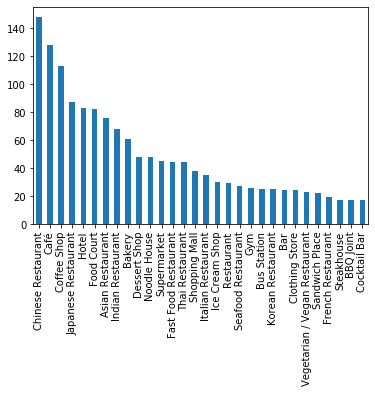

In [10]:
# align template for Venue Category
venueDFClean = venueDF.copy()
venueDFClean['Venue Category'] = venueDFClean['Venue Category'].apply( lambda x: x[0])
venueDFClean['Venue Category'].value_counts()[:30].plot(kind='bar')
venueDFClean['Venue Category'].unique().shape
venueDFClean['Venue Category'].value_counts()

In [11]:
# Visulization

def PlotMap(address, LLLDF, color_typ = 'single', cluster_label = 'cluster', color = 'Blue',map = None):
    '''
    address is city: Singapore/Torrento, Cananda
    LLLDF is DF containing Latitude, Longitude and Label
    if color_typ == rainbow, then extract numbers from LLLDF as rainbow color
    '''
    if map is None:
        # get coordinate of target
        geolocator = Nominatim()
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        # create map of SG using latitude and longitude values
        map_target = folium.Map(location=[latitude, longitude], zoom_start=10)
    else:
        map_target = map
    if cluster_label not in LLLDF.columns:
        LLLDF[cluster_label] = 0
    if color_typ == 'rainbow':
        # set color 
        k = LLLDF[cluster_label].max()+1
        x = np.arange(k)
        ys = [i + x + (i*x)**2 for i in range(k)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to map
    for lat, lng, dflabel, cluster in zip(LLLDF['Latitude'], LLLDF['Longitude'], LLLDF['Label'], LLLDF[cluster_label]):
        label = '{}'.format(dflabel)
        label = folium.Popup(label, parse_html=True)
        if color_typ == 'rainbow':
            color, fill_color = rainbow[int(cluster)-1], rainbow[int(cluster)-1]
        else:
            color, fill_color = color, color
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=fill_color,
            fill_opacity=0.7,
            parse_html=False).add_to(map_target)  
    return map_target
address = 'Singapore'
LLLDF = LocationDF.reset_index().rename(columns = {'index':'Label'})
map_sg=PlotMap(address, LLLDF)
map_sg

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  # This is added back by InteractiveShellApp.init_path()


## Clean Data

- Del unsignificant features: del venues categories with too little venue within group
- Find food relevant features

In [113]:
# category feature count
temp = venueDFClean['Venue Category'].value_counts().reset_index().rename(columns={'index':'Venue Category Name','Venue Category':'Venue Counts'})
tempplot = temp['Venue Counts'].value_counts().reset_index().rename(columns={'index':'Number of Venues','Venue Counts':'Category Numbers'}).sort_values(by='Number of Venues')
tempplot.head(12)

,Number of Venues,Category Numbers
0,1,86
1,2,48
3,3,14
4,4,13
2,5,15
6,6,8
7,7,8
5,8,12
15,9,3
13,10,4


In [123]:
'total of {} samples dropped'.format(2466-1888)

'total of 578 samples dropped'

In [120]:
# Clean Data, del unsignificant features
threshold = 10
temp = venueDFClean['Venue Category'].value_counts().reset_index()
FeatureList = temp[temp['Venue Category']>=threshold]['index'].values
venueClean1 = venueDFClean[venueDFClean['Venue Category'].isin(FeatureList)]
print('total of {} samples left'.format(venueClean1.shape[0]))
venueClean1.head()

total of 1888 samples left


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Raffles Place,1.28189,103.84912,Amoy Hotel,1.283118,103.848539,Hotel
1,Raffles Place,1.28189,103.84912,Fat Saigon Boy,1.282977,103.849068,Vietnamese Restaurant
2,Raffles Place,1.28189,103.84912,Luke's Oyster Bar & Chop House,1.282459,103.847240,Seafood Restaurant
4,Raffles Place,1.28189,103.84912,Grain Traders,1.281468,103.850039,Restaurant
5,Raffles Place,1.28189,103.84912,Shake Farm,1.281878,103.848169,Coffee Shop


In [72]:
# Find food relevant features
UCFeatures0 = venueClean1['Venue Category'].unique().tolist()

kwDic = {'Restaurant':['BBQ Joint',  'Restaurant',  'Food Court','Salad',  'Sandwich', 'Soup', 'Steakhouse','Noodle', 'Bistro'],
         'FastF':[ 'Pizza',  'Fried Chicken', 'Fast Food'],
         'Drink':[ 'Bubble Tea Shop', 'Café', 'Bar', 'Coffee', ],
         'Snack':['Bakery', 'Yogurt',  'Ice Cream', 'Dessert',  'Snack' ]
        }

def FeatureFilter(kwDic, UCFeatures):
    UCFeatures = set(UCFeatures)
    rst = {}
    for key in kwDic.keys():
        l = kwDic[key]
        out = set()
        for kw in l:
            for i in UCFeatures:
                if kw in i:
                    out.add(i)
            UCFeatures -= out
        rst[key] = list(out)
    return rst, UCFeatures
# classification
FeatureDic, UCFeatures = FeatureFilter(kwDic, UCFeatures0)
FeatureDic['Unclassificed'] = list(UCFeatures)
# wrong assignment adjust
FeatureDic['FastF'].append(FeatureDic['Restaurant'].pop(FeatureDic['Restaurant'].index('Fast Food Restaurant')))
# kept feature list
FoodFeature = set(UCFeatures0) - UCFeatures
pd.DataFrame(np.array(FeatureDic['Restaurant']).reshape(-1,3))

,0,1,2
0,Sandwich Place,BBQ Joint,Soup Place
1,Steakhouse,Vegetarian / Vegan Restaurant,American Restaurant
2,Vietnamese Restaurant,French Restaurant,Seafood Restaurant
3,Korean Restaurant,Thai Restaurant,Asian Restaurant
4,Indian Restaurant,Italian Restaurant,Food Court
5,Indonesian Restaurant,Malay Restaurant,Ramen Restaurant
6,Japanese Restaurant,Dumpling Restaurant,Chinese Restaurant
7,Restaurant,Noodle House,Salad Place
8,Bistro,Dim Sum Restaurant,Sushi Restaurant


In [121]:
# kept samples
venueClean2=venueClean1[venueClean1['Venue Category'].isin(FoodFeature)]
print('total of {} samples left'.format(venueClean2.shape[0]))
venueClean2.head()

total of 1460 samples left


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Raffles Place,1.28189,103.84912,Fat Saigon Boy,1.282977,103.849068,Vietnamese Restaurant
2,Raffles Place,1.28189,103.84912,Luke's Oyster Bar & Chop House,1.282459,103.847240,Seafood Restaurant
4,Raffles Place,1.28189,103.84912,Grain Traders,1.281468,103.850039,Restaurant
5,Raffles Place,1.28189,103.84912,Shake Farm,1.281878,103.848169,Coffee Shop
6,Raffles Place,1.28189,103.84912,Cha Tra Mue,1.283469,103.848293,Café


In [117]:
venueFinal = venueClean2
'total of {} venue categories left'.format(len(venueFinal['Venue Category'].unique()))

'total of 41 venue categories left'

## Part 3 Methodology
> section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

Methodology:
- Explore and cluster the neighborhoods
- Select the best cluster to open a new restaurant

## Explore neighborhoods

- Little India, China Town venue characters
- If any pattern in Chinese/ Indian/ Malay Restaurants Locations

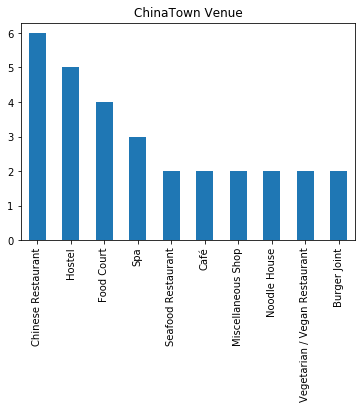

In [95]:
ChinaTown  = " People's Park"
CTDF = venueDFClean[venueDFClean['Neighborhood']==ChinaTown]
CTDF['Venue Category'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar',title='ChinaTown Venue')

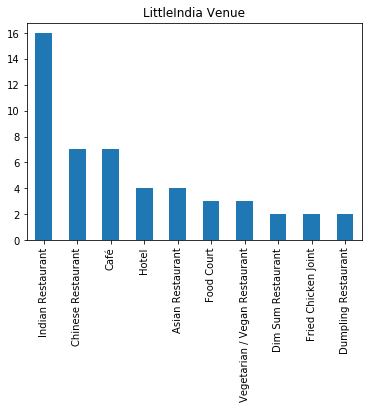

In [96]:
LittleIndia = 'Little India'
LIDF = venueDFClean[venueDFClean['Neighborhood']==LittleIndia]
LIDF['Venue Category'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar',title='LittleIndia Venue')

In [144]:
CNVenue = 'Chinese Restaurant'
venueFinal[venueFinal['Venue Category']==CNVenue].shape

(148, 7)

In [145]:
IDVenue = 'Indian Restaurant'
venueFinal[venueFinal['Venue Category']==IDVenue].shape

(68, 7)

In [146]:
MLVenue = 'Malay Restaurant'
venueFinal[venueFinal['Venue Category']==MLVenue].shape

(12, 7)

In [126]:
Features = pd.get_dummies(venueFinal[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
SG_onehot = pd.concat([venueFinal[['Neighborhood']],Features],axis=1).reset_index(drop=True)

SG_grouped = SG_onehot.groupby(['Neighborhood']).sum().reset_index()
SG_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Bubble Tea Shop,Café,Chinese Restaurant,...,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,Amber Road,1,2,0,2,1,0,0,4,4,...,0,0,0,0,1,1,0,0,1,0
1,Ang Mo Kio,0,1,0,1,0,0,2,0,1,...,2,1,1,0,0,2,0,1,0,0
2,Beach Road (part),0,2,0,5,1,0,0,3,2,...,2,1,0,0,0,0,2,1,2,1
3,Braddell,0,0,0,0,0,0,0,0,2,...,0,3,0,0,0,0,0,0,0,0
4,Bukit Panjang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


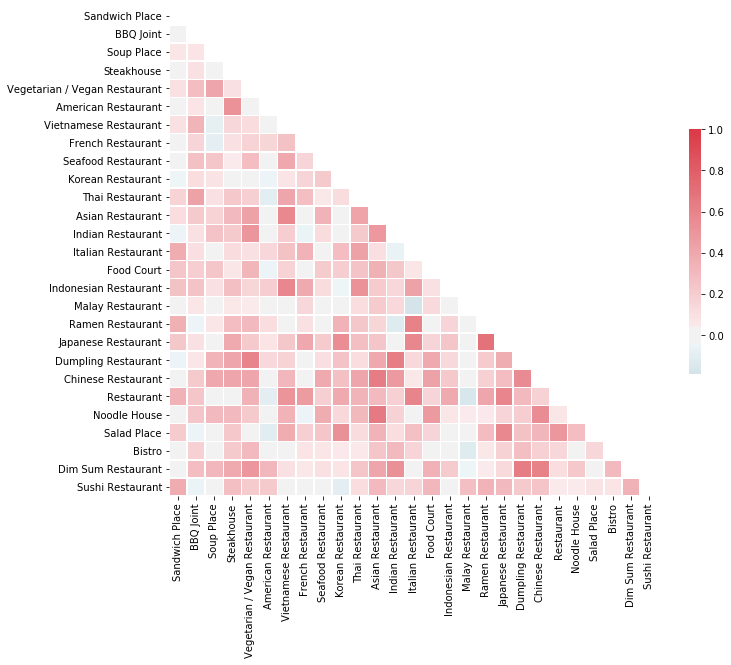

In [140]:
CorrFeatures = FeatureDic['Restaurant']
RestaurantCorr = SG_grouped[CorrFeatures].corr()

def CorrPlot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

CorrPlot(RestaurantCorr)

(61, 61)


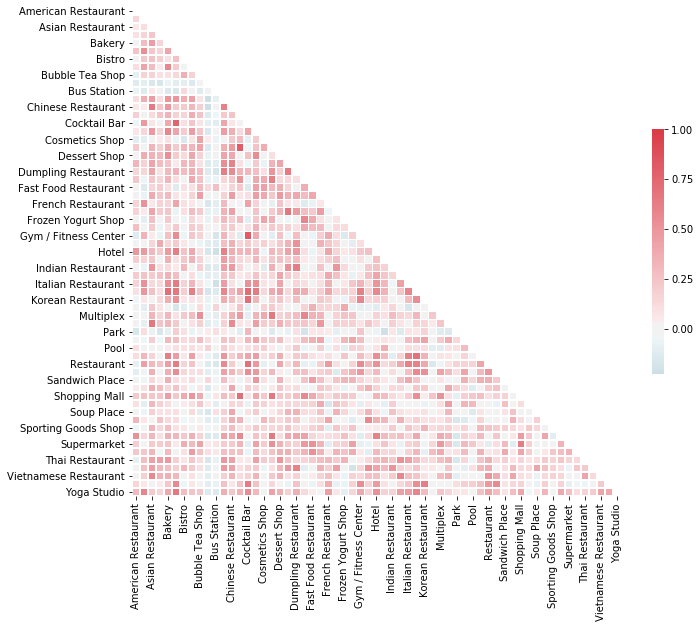

In [141]:
FeaturesAll = pd.get_dummies(venueClean1[['Venue Category']], prefix="", prefix_sep="")
Allgrouped = pd.concat([venueClean1[['Neighborhood']],FeaturesAll],axis=1).reset_index(drop=True).groupby(['Neighborhood']).sum().reset_index()
print(Allgrouped.corr().shape)
CorrPlot(Allgrouped.corr())

# Clustering

In [147]:
from sklearn.cluster import KMeans 

In [191]:

def KMean(kclusters, SG_grouped):
    # set number of clusters
    

    SG_grouped_clustering = SG_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, n_init=100).fit(SG_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    SG_grouped['Cluster'] = kmeans.labels_
    cluster_df = SG_grouped#[['Neighborhood','Cluster']]
    return cluster_df
kclusters = 4
cluster_df = KMean(kclusters, SG_grouped)
# cluster with location
ClusterLocation = pd.merge(LLLDF[['Label','Latitude','Longitude']], cluster_df, left_on = 'Label',right_on = 'Neighborhood').drop('Neighborhood',axis = 1)
ClusterLocation.head()

,Label,Latitude,Longitude,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Bubble Tea Shop,...,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Cluster
0,Raffles Place,1.28189,103.84912,0,1,0,1,3,0,0,...,1,0,0,0,0,0,0,1,4,0
1,Marina,1.29227,103.76325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,People's Park,1.28444,103.84194,0,0,1,0,0,0,0,...,2,0,1,0,0,0,2,0,0,3
3,Tanjong Pagar,1.27889,103.84539,0,2,0,5,3,0,0,...,1,0,1,0,0,1,1,0,1,0
4,Bukit Merah,1.28417,103.82306,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1


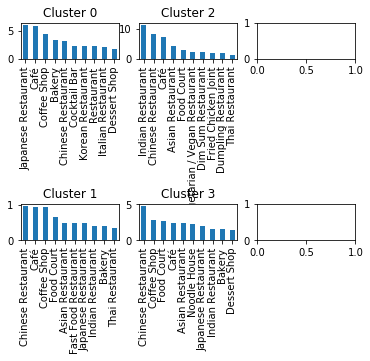

In [192]:
# Analysis Cluster Characters
K = ClusterLocation.Cluster.max()
drop_cols = ['Latitude','Longitude','Label','Cluster']

#plt.figure(figsize=(5,20))
fig, ax = plt.subplots(2,3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=4)
for i in range(K+1):
    #i = 0
    x,y = i//2, i%2
    tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
    tempseries = tempdf.mean().sort_values()[::-1]
    tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i), ax = ax[y,x])

plt.show()

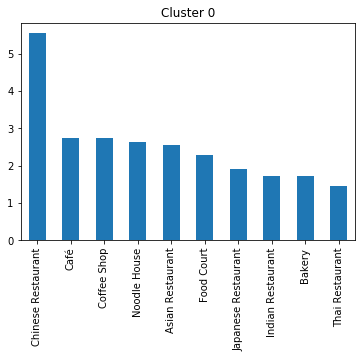

In [186]:
i=0
tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
tempseries = tempdf.mean().sort_values()[::-1]
tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i))

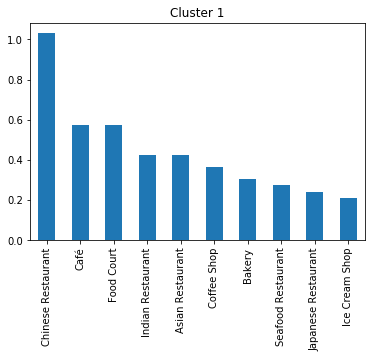

In [187]:
i=1
tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
tempseries = tempdf.mean().sort_values()[::-1]
tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i))

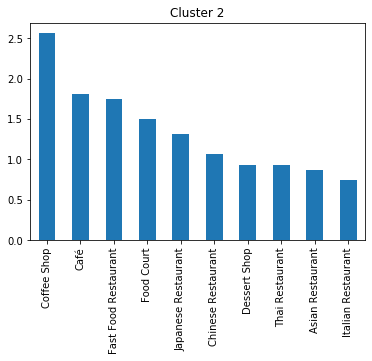

In [179]:
i=2
tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
tempseries = tempdf.mean().sort_values()[::-1]
tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i))

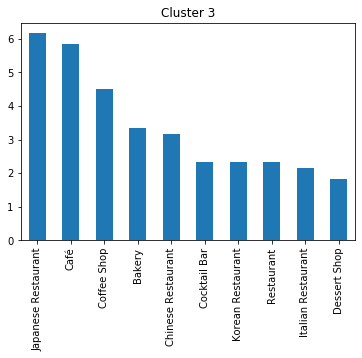

In [180]:
i=3
tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
tempseries = tempdf.mean().sort_values()[::-1]
tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i))

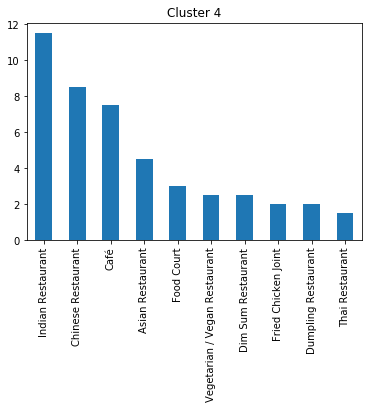

In [181]:
i=4
tempdf = ClusterLocation[ClusterLocation['Cluster']==i].drop(drop_cols, axis = 1)
tempseries = tempdf.mean().sort_values()[::-1]
tempseries[:10].plot(kind='bar', title = 'Cluster {}'.format(i))


In [190]:
# cluster view
mapDF = ClusterLocation[['Latitude','Longitude','Label','Cluster']]
mapDF = mapDF[mapDF['Cluster'].isin([4])]
PlotMap('Singapore', mapDF, color = 'Blue')

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  # This is added back by InteractiveShellApp.init_path()
